In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    kernel_size = 64
    filter_size = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3*kernel_size, filters=filter_size, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        target_kernel_size = 3 * (kernel_size//(2**(i+1)))
        model.add(Conv1D (kernel_size=target_kernel_size if target_kernel_size != 0 else 3, 
                          filters=filter_size*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         12352     
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,368
Trainable params: 16,396,368
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5333, 64)          196672    
_________________________________________________________________
activation_17 (Activation)   (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5333, 64)          196672    
_________________________________________________________________
activation_38 (Activation)   (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0319 - acc: 0.3415
Epoch 00001: val_loss improved from inf to 1.63868, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_1_conv_checkpoint/001-1.6387.hdf5
36805/36805 [==============================] - 33s 894us/sample - loss: 2.0317 - acc: 0.3415 - val_loss: 1.6387 - val_acc: 0.4764
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3607 - acc: 0.5784
Epoch 00002: val_loss improved from 1.63868 to 1.50714, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_1_conv_checkpoint/002-1.5071.hdf5
36805/36805 [==============================] - 32s 859us/sample - loss: 1.3607 - acc: 0.5783 - val_loss: 1.5071 - val_acc: 0.5283
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0667 - acc: 0.6813
Epoch 00003: val_loss did not improve from 1.50714
36805/

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9924
Epoch 00029: val_loss did not improve from 1.50422
36805/36805 [==============================] - 31s 851us/sample - loss: 0.0512 - acc: 0.9924 - val_loss: 3.0354 - val_acc: 0.5092
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9936
Epoch 00030: val_loss did not improve from 1.50422
36805/36805 [==============================] - 31s 847us/sample - loss: 0.0434 - acc: 0.9936 - val_loss: 3.0975 - val_acc: 0.5024
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9926
Epoch 00031: val_loss did not improve from 1.50422
36805/36805 [==============================] - 31s 847us/sample - loss: 0.0458 - acc: 0.9926 - val_loss: 3.1327 - val_acc: 0.5013
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9943
Epoch 00032: val_loss did not improve from 1.50422
36805/36805 [=====

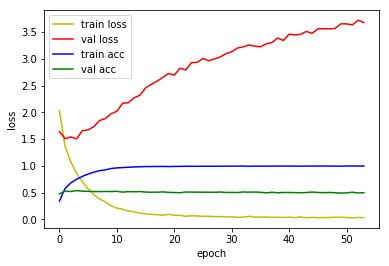

4815/4815 [==============================] - 2s 397us/sample - loss: 1.5956 - acc: 0.5009
Loss: 1.5955962598509505 Accuracy: 0.5009346

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7802 - acc: 0.4313
Epoch 00001: val_loss improved from inf to 1.26084, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_2_conv_checkpoint/001-1.2608.hdf5
36805/36805 [==============================] - 145s 4ms/sample - loss: 1.7802 - acc: 0.4313 - val_loss: 1.2608 - val_acc: 0.6222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1165 - acc: 0.6621
Epoch 00002: val_loss improved from 1.26084 to 0.98988, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_2_conv_checkpoint/002-0.9899.hdf5
36805/36805 [==============================] - 143s 4ms/sample - loss: 1.1164 - acc: 0.6621 - val_loss: 0.9899 - val_acc: 0.7095
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9917
Epoch 00029: val_loss did not improve from 0.88377
36805/36805 [==============================] - 142s 4ms/sample - loss: 0.0391 - acc: 0.9917 - val_loss: 1.6344 - val_acc: 0.7505
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9961
Epoch 00030: val_loss did not improve from 0.88377
36805/36805 [==============================] - 141s 4ms/sample - loss: 0.0239 - acc: 0.9961 - val_loss: 1.7181 - val_acc: 0.7338
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9930
Epoch 00031: val_loss did not improve from 0.88377
36805/36805 [==============================] - 142s 4ms/sample - loss: 0.0336 - acc: 0.9930 - val_loss: 1.6508 - val_acc: 0.7473
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9948
Epoch 00032: val_loss did not improve from 0.88377
36805/36805 [========

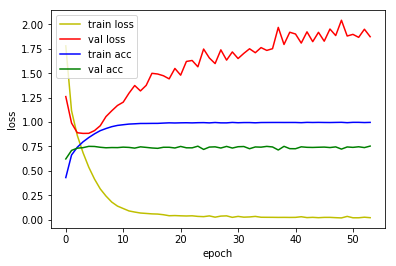

4815/4815 [==============================] - 4s 797us/sample - loss: 0.9282 - acc: 0.7259
Loss: 0.9281952437953415 Accuracy: 0.7258567

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8914 - acc: 0.3868
Epoch 00001: val_loss improved from inf to 1.38199, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_3_conv_checkpoint/001-1.3820.hdf5
36805/36805 [==============================] - 165s 4ms/sample - loss: 1.8913 - acc: 0.3868 - val_loss: 1.3820 - val_acc: 0.5609
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2320 - acc: 0.6216
Epoch 00002: val_loss improved from 1.38199 to 1.04554, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_3_conv_checkpoint/002-1.0455.hdf5
36805/36805 [==============================] - 163s 4ms/sample - loss: 1.2321 - acc: 0.6216 - val_loss: 1.0455 - val_acc: 0.6741
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9850
Epoch 00028: val_loss did not improve from 0.65510
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0548 - acc: 0.9850 - val_loss: 1.1445 - val_acc: 0.8169
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9892
Epoch 00029: val_loss did not improve from 0.65510
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0419 - acc: 0.9892 - val_loss: 1.1364 - val_acc: 0.8106
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9892
Epoch 00030: val_loss did not improve from 0.65510
36805/36805 [==============================] - 161s 4ms/sample - loss: 0.0420 - acc: 0.9892 - val_loss: 1.1165 - val_acc: 0.8118
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9878
Epoch 00031: val_loss did not improve from 0.65510
36805/36805 [========

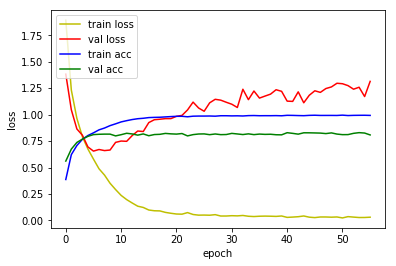

4815/4815 [==============================] - 4s 873us/sample - loss: 0.7212 - acc: 0.7886
Loss: 0.7212270665267794 Accuracy: 0.7885774

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9806 - acc: 0.3486
Epoch 00001: val_loss improved from inf to 1.46296, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_4_conv_checkpoint/001-1.4630.hdf5
36805/36805 [==============================] - 169s 5ms/sample - loss: 1.9805 - acc: 0.3486 - val_loss: 1.4630 - val_acc: 0.5295
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3543 - acc: 0.5693
Epoch 00002: val_loss improved from 1.46296 to 1.18832, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_4_conv_checkpoint/002-1.1883.hdf5
36805/36805 [==============================] - 166s 5ms/sample - loss: 1.3543 - acc: 0.5694 - val_loss: 1.1883 - val_acc: 0.6278
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9641
Epoch 00025: val_loss did not improve from 0.46810
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.1160 - acc: 0.9641 - val_loss: 0.5563 - val_acc: 0.8840
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9667
Epoch 00026: val_loss did not improve from 0.46810
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.1069 - acc: 0.9667 - val_loss: 0.6016 - val_acc: 0.8721
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1072 - acc: 0.9667
Epoch 00027: val_loss did not improve from 0.46810
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.1072 - acc: 0.9667 - val_loss: 0.6059 - val_acc: 0.8705
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0977 - acc: 0.9692
Epoch 00028: val_loss did not improve from 0.46810
36805/36805 [=====================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9858
Epoch 00055: val_loss did not improve from 0.46810
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0487 - acc: 0.9858 - val_loss: 0.7225 - val_acc: 0.8803
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9867
Epoch 00056: val_loss did not improve from 0.46810
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0450 - acc: 0.9867 - val_loss: 0.7652 - val_acc: 0.8758
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9895
Epoch 00057: val_loss did not improve from 0.46810
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0381 - acc: 0.9895 - val_loss: 0.7834 - val_acc: 0.8765
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9882
Epoch 00058: val_loss did not improve from 0.46810
36805/36805 [========

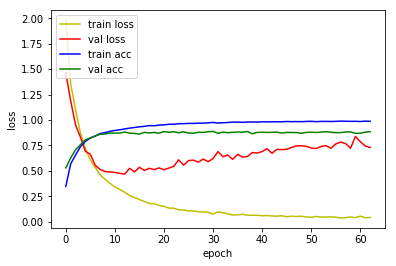

4815/4815 [==============================] - 4s 925us/sample - loss: 0.5719 - acc: 0.8482
Loss: 0.571932884280184 Accuracy: 0.84818274

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0394 - acc: 0.3353
Epoch 00001: val_loss improved from inf to 1.61896, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_5_conv_checkpoint/001-1.6190.hdf5
36805/36805 [==============================] - 172s 5ms/sample - loss: 2.0394 - acc: 0.3353 - val_loss: 1.6190 - val_acc: 0.4673
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4022 - acc: 0.5460
Epoch 00002: val_loss improved from 1.61896 to 1.18917, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_5_conv_checkpoint/002-1.1892.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 1.4022 - acc: 0.5460 - val_loss: 1.1892 - val_acc: 0.6352
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9631
Epoch 00025: val_loss did not improve from 0.39847
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1152 - acc: 0.9631 - val_loss: 0.5117 - val_acc: 0.8933
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1128 - acc: 0.9639
Epoch 00026: val_loss did not improve from 0.39847
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1128 - acc: 0.9639 - val_loss: 0.4397 - val_acc: 0.9012
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9655
Epoch 00027: val_loss did not improve from 0.39847
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.1069 - acc: 0.9655 - val_loss: 0.4656 - val_acc: 0.9047
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1060 - acc: 0.9656
Epoch 00028: val_loss did not improve from 0.39847
36805/36805 [=====================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9827
Epoch 00055: val_loss did not improve from 0.39847
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0515 - acc: 0.9827 - val_loss: 0.5489 - val_acc: 0.9061
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9855
Epoch 00056: val_loss did not improve from 0.39847
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0459 - acc: 0.9855 - val_loss: 0.5469 - val_acc: 0.9082
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9861
Epoch 00057: val_loss did not improve from 0.39847
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0444 - acc: 0.9861 - val_loss: 0.5507 - val_acc: 0.9133
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9841
Epoch 00058: val_loss did not improve from 0.39847
36805/36805 [========

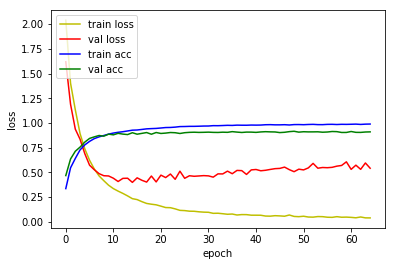

4815/4815 [==============================] - 5s 959us/sample - loss: 0.4523 - acc: 0.8760
Loss: 0.45233589846520905 Accuracy: 0.87601244

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2381 - acc: 0.2551
Epoch 00001: val_loss improved from inf to 1.55108, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_6_conv_checkpoint/001-1.5511.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 2.2381 - acc: 0.2551 - val_loss: 1.5511 - val_acc: 0.5013
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4388 - acc: 0.5272
Epoch 00002: val_loss improved from 1.55108 to 1.14374, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_6_conv_checkpoint/002-1.1437.hdf5
36805/36805 [==============================] - 174s 5ms/sample - loss: 1.4388 - acc: 0.5272 - val_loss: 1.1437 - val_acc: 0.6478
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1439 - acc: 0.9527
Epoch 00025: val_loss did not improve from 0.25300
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.1439 - acc: 0.9527 - val_loss: 0.2661 - val_acc: 0.9280
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1339 - acc: 0.9564
Epoch 00026: val_loss improved from 0.25300 to 0.25080, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_6_conv_checkpoint/026-0.2508.hdf5
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.1339 - acc: 0.9564 - val_loss: 0.2508 - val_acc: 0.9348
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1286 - acc: 0.9577
Epoch 00027: val_loss did not improve from 0.25080
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.1287 - acc: 0.9577 - val_loss: 0.2769 - val_acc: 0.9273
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9813
Epoch 00054: val_loss did not improve from 0.24618
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0572 - acc: 0.9813 - val_loss: 0.2970 - val_acc: 0.9392
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9806
Epoch 00055: val_loss did not improve from 0.24618
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0594 - acc: 0.9806 - val_loss: 0.2804 - val_acc: 0.9427
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9821
Epoch 00056: val_loss did not improve from 0.24618
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0538 - acc: 0.9821 - val_loss: 0.3236 - val_acc: 0.9383
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9822
Epoch 00057: val_loss did not improve from 0.24618
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9890
Epoch 00084: val_loss did not improve from 0.24618
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0341 - acc: 0.9890 - val_loss: 0.3150 - val_acc: 0.9427
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9868
Epoch 00085: val_loss did not improve from 0.24618
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0401 - acc: 0.9868 - val_loss: 0.3345 - val_acc: 0.9413
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9892
Epoch 00086: val_loss did not improve from 0.24618
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0327 - acc: 0.9892 - val_loss: 0.3488 - val_acc: 0.9387

1D_CNN_custom_kernel_192_DO_6_conv Model


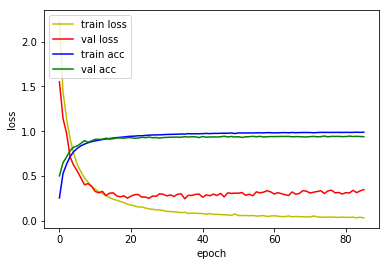

4815/4815 [==============================] - 5s 981us/sample - loss: 0.3056 - acc: 0.9225
Loss: 0.3056400315598164 Accuracy: 0.92253375

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3085 - acc: 0.2393
Epoch 00001: val_loss improved from inf to 1.65231, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_7_conv_checkpoint/001-1.6523.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 2.3086 - acc: 0.2393 - val_loss: 1.6523 - val_acc: 0.4929
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5534 - acc: 0.4916
Epoch 00002: val_loss improved from 1.65231 to 1.17613, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_7_conv_checkpoint/002-1.1761.hdf5
36805/36805 [==============================] - 172s 5ms/sample - loss: 1.5532 - acc: 0.4916 - val_loss: 1.1761 - val_acc: 0.6322
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1819 - acc: 0.9413
Epoch 00024: val_loss improved from 0.20627 to 0.20354, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_7_conv_checkpoint/024-0.2035.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1819 - acc: 0.9413 - val_loss: 0.2035 - val_acc: 0.9415
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1774 - acc: 0.9422
Epoch 00025: val_loss did not improve from 0.20354
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1774 - acc: 0.9422 - val_loss: 0.2103 - val_acc: 0.9434
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1687 - acc: 0.9457
Epoch 00026: val_loss improved from 0.20354 to 0.19926, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_7_conv_checkpoint/026-0.1993.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1686 - acc: 0.9457 - val_

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9711
Epoch 00051: val_loss did not improve from 0.18144
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0847 - acc: 0.9711 - val_loss: 0.1827 - val_acc: 0.9550
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0887 - acc: 0.9705
Epoch 00052: val_loss did not improve from 0.18144
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0887 - acc: 0.9705 - val_loss: 0.1848 - val_acc: 0.9539
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0858 - acc: 0.9704
Epoch 00053: val_loss did not improve from 0.18144
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0858 - acc: 0.9704 - val_loss: 0.1970 - val_acc: 0.9502
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0802 - acc: 0.9728
Epoch 00054: val_loss did not improve from 0.18144
36805/36805 [========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9799
Epoch 00081: val_loss did not improve from 0.18144
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0589 - acc: 0.9799 - val_loss: 0.2053 - val_acc: 0.9599
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9822
Epoch 00082: val_loss did not improve from 0.18144
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0540 - acc: 0.9822 - val_loss: 0.2279 - val_acc: 0.9529
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9811
Epoch 00083: val_loss did not improve from 0.18144
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0543 - acc: 0.9811 - val_loss: 0.2301 - val_acc: 0.9536
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9804
Epoch 00084: val_loss did not improve from 0.18144
36805/36805 [========

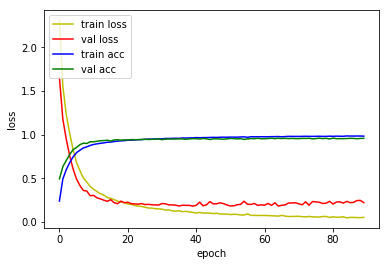

4815/4815 [==============================] - 5s 991us/sample - loss: 0.2434 - acc: 0.9350
Loss: 0.24343668199216836 Accuracy: 0.9349948

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4067 - acc: 0.2063
Epoch 00001: val_loss improved from inf to 1.65650, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_8_conv_checkpoint/001-1.6565.hdf5
36805/36805 [==============================] - 176s 5ms/sample - loss: 2.4066 - acc: 0.2063 - val_loss: 1.6565 - val_acc: 0.4635
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5291 - acc: 0.5011
Epoch 00002: val_loss improved from 1.65650 to 1.00675, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_8_conv_checkpoint/002-1.0068.hdf5
36805/36805 [==============================] - 172s 5ms/sample - loss: 1.5291 - acc: 0.5011 - val_loss: 1.0068 - val_acc: 0.6879
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.1991 - acc: 0.9369
Epoch 00023: val_loss improved from 0.17660 to 0.15241, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_8_conv_checkpoint/023-0.1524.hdf5
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.1991 - acc: 0.9369 - val_loss: 0.1524 - val_acc: 0.9499
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1927 - acc: 0.9389
Epoch 00024: val_loss did not improve from 0.15241
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.1927 - acc: 0.9389 - val_loss: 0.1561 - val_acc: 0.9527
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1860 - acc: 0.9396
Epoch 00025: val_loss improved from 0.15241 to 0.14965, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_8_conv_checkpoint/025-0.1497.hdf5
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.1860 - acc: 0.9396 - val_loss: 0.1497 

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0965 - acc: 0.9681
Epoch 00051: val_loss did not improve from 0.14240
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0965 - acc: 0.9681 - val_loss: 0.1849 - val_acc: 0.9504
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0957 - acc: 0.9680
Epoch 00052: val_loss did not improve from 0.14240
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0957 - acc: 0.9680 - val_loss: 0.1457 - val_acc: 0.9597
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0913 - acc: 0.9693
Epoch 00053: val_loss did not improve from 0.14240
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0913 - acc: 0.9693 - val_loss: 0.1688 - val_acc: 0.9564
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0899 - acc: 0.9697
Epoch 00054: val_loss did not improve from 0.14240
36805/36805 [========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9812
Epoch 00080: val_loss did not improve from 0.13888
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0548 - acc: 0.9812 - val_loss: 0.1485 - val_acc: 0.9672
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9796
Epoch 00081: val_loss did not improve from 0.13888
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0626 - acc: 0.9796 - val_loss: 0.1532 - val_acc: 0.9630
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9816
Epoch 00082: val_loss did not improve from 0.13888
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0538 - acc: 0.9816 - val_loss: 0.1462 - val_acc: 0.9695
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9827
Epoch 00083: val_loss did not improve from 0.13888
36805/36805 [========

Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9874
Epoch 00110: val_loss did not improve from 0.13888
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0399 - acc: 0.9874 - val_loss: 0.1734 - val_acc: 0.9634

1D_CNN_custom_kernel_192_DO_8_conv Model


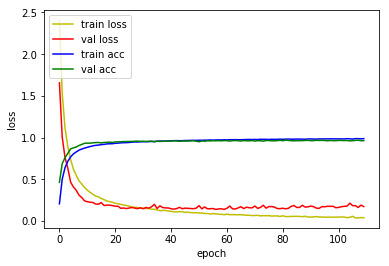

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1881 - acc: 0.9489
Loss: 0.188122254530759 Accuracy: 0.94890964

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0013 - acc: 0.3451
Epoch 00001: val_loss improved from inf to 1.08700, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_9_conv_checkpoint/001-1.0870.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 2.0013 - acc: 0.3451 - val_loss: 1.0870 - val_acc: 0.6688
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0736 - acc: 0.6582
Epoch 00002: val_loss improved from 1.08700 to 0.68875, saving model to model/checkpoint/1D_CNN_custom_kernel_192_DO_9_conv_checkpoint/002-0.6888.hdf5
36805/36805 [==============================] - 174s 5ms/sample - loss: 1.0736 - acc: 0.6582 - val_loss: 0.6888 - val_acc: 0.7980
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1414 - acc: 0.9538
Epoch 00025: val_loss did not improve from 0.15246
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.1413 - acc: 0.9538 - val_loss: 0.1558 - val_acc: 0.9562
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9565
Epoch 00026: val_loss did not improve from 0.15246
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.1327 - acc: 0.9564 - val_loss: 0.1547 - val_acc: 0.9567
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1279 - acc: 0.9578
Epoch 00027: val_loss did not improve from 0.15246
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.1279 - acc: 0.9578 - val_loss: 0.1649 - val_acc: 0.9520
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1237 - acc: 0.9589
Epoch 00028: val_loss did not improve from 0.15246
36805/36805 [=====================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9792
Epoch 00054: val_loss did not improve from 0.13928
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0631 - acc: 0.9792 - val_loss: 0.1671 - val_acc: 0.9620
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9798
Epoch 00055: val_loss did not improve from 0.13928
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0616 - acc: 0.9798 - val_loss: 0.1608 - val_acc: 0.9660
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0597 - acc: 0.9797
Epoch 00056: val_loss did not improve from 0.13928
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0596 - acc: 0.9797 - val_loss: 0.1697 - val_acc: 0.9653
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0583 - acc: 0.9807
Epoch 00057: val_loss did not improve from 0.13928
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9868
Epoch 00084: val_loss did not improve from 0.13928
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0407 - acc: 0.9868 - val_loss: 0.1863 - val_acc: 0.9627
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0570 - acc: 0.9814
Epoch 00085: val_loss did not improve from 0.13928
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0571 - acc: 0.9814 - val_loss: 0.2047 - val_acc: 0.9599
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9869
Epoch 00086: val_loss did not improve from 0.13928
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0390 - acc: 0.9869 - val_loss: 0.1830 - val_acc: 0.9665

1D_CNN_custom_kernel_192_DO_9_conv Model


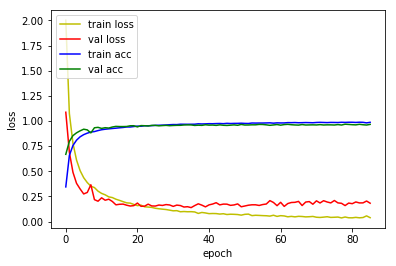

4815/4815 [==============================] - 5s 997us/sample - loss: 0.1974 - acc: 0.9479
Loss: 0.19740201153658013 Accuracy: 0.9478712



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_kernel_192_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,368
Trainable params: 16,396,368
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 448us/sample - loss: 1.5956 - acc: 0.500

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4523 - acc: 0.8760
Loss: 0.45233589846520905 Accuracy: 0.87601244

1D_CNN_custom_kernel_192_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (N

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1881 - acc: 0.9489
Loss: 0.188122254530759 Accuracy: 0.94890964

1D_CNN_custom_kernel_192_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           (Non

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,368
Trainable params: 16,396,368
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 498us/sample - loss: 3.7688 - acc: 0.478

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6197 - acc: 0.8908
Loss: 0.6197051307617814 Accuracy: 0.89075804

1D_CNN_custom_kernel_192_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (No

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2295 - acc: 0.9516
Loss: 0.22947452924323586 Accuracy: 0.95160955

1D_CNN_custom_kernel_192_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         393280    
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           (N